# 1. The Model

## 1.1 Data Loading

### 1.1.1 Install Dependencies

In [2]:
# data manipulation library
!pip install pandas  

# used for mathematical computation/statistics
!pip install numpy  

# data plotting and visualization
!pip install matplotlib  

# for plotting model
!pip install scikit-plot

!pip install pickle-mixin

! pip install py7zr

!pip install imblearn

### 1.1.2 Import Modules

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from itertools import chain

# Modules needed for modeling & evaluation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import scikitplot.plotters as skplt
import py7zr
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import log_loss, plot_confusion_matrix, accuracy_score
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score, classification_report
import pickle
from sklearn.model_selection import cross_val_predict
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.compose import make_column_transformer
from sklearn import set_config
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks

### 1.1.3 Load Sample Submissions

In [ ]:
cwd = os.getcwd()
sample_submission_path = os.path.join(cwd, "msk-redefining-cancer-treatment/stage2_sample_submission.csv.7z")
private_solution_stage_1_path = os.path.join(cwd, "msk-redefining-cancer-treatment/stage1_solution_filtered.csv.7z")
private_solution_stage_2_path = os.path.join(cwd, "msk-redefining-cancer-treatment/stage_2_private_solution.csv.7z")

with py7zr.SevenZipFile(sample_submission_path, mode='r') as sample_submission:
    sample_submission.extractall()
    
with py7zr.SevenZipFile(private_solution_stage_1_path, mode='r') as private_solution_stage_1:
    private_solution_stage_1.extractall()

with py7zr.SevenZipFile(private_solution_stage_2_path, mode='r') as private_solution_stage_2:
    private_solution_stage_2.extractall()

### 1.1.4 Read in datasets

In [5]:
# Variant dataframes where variations are grouped by hydrophobicity.
# Miscellaneous variations are not grouped together.
training_var_clean = pd.read_csv('training_variants_clean.csv')
test_var_clean = pd.read_csv('test_variants_clean.csv')
test_var_clean_stage2 = pd.read_csv('test_variants_clean_stage2.csv')

In [6]:
# Text data with all 9 classes.
training_text_clean = pd.read_csv('training_text_clean.csv')
test_text_clean = pd.read_csv('test_text_clean.csv')
test_text_clean_stage2 = pd.read_csv('test_text_clean_stage2.csv')

[Use .astype('U').values instead of .values.astype('U') to avoid using too much memory](https://stackoverflow.com/questions/49957069/python-how-to-avoid-memoryerror-when-transform-text-data-into-unicode-using-ast)


In [7]:
# Convert text to unicode - required for sklearn.
training_text_clean["TEXT"] = training_text_clean["TEXT"].astype('U').values
# Convert text to unicode - required for sklearn.
test_text_clean["TEXT"] = test_text_clean["TEXT"].astype('U').values
test_text_clean_stage2["TEXT"] = test_text_clean_stage2["TEXT"].astype('U').values

In [8]:
# this df is for stage 1
merged_df_label_test = pd.merge(test_var_clean,test_text_clean,on=['ID'])
# stage 2 below
merged_df_label_test_stage2 = pd.merge(test_var_clean_stage2,test_text_clean_stage2,on=['ID'])

## 1.2 Prepare Data

In [9]:
# Merge training var and text data together
merged_df_label = pd.merge(training_var_clean,training_text_clean,on=['ID'])

In [10]:
# Factorize features
pipeline_df_merged = merged_df_label.copy()
pipeline_df_merged["Gene"] = pipeline_df_merged["Gene"].factorize()[0]
pipeline_df_merged["Variation"] = pipeline_df_merged["Variation"].factorize()[0]

In [11]:
# Stage 2 Test Data
pipeline_test_df_merged = merged_df_label_test_stage2.copy()
pipeline_test_df_merged["Gene"] = pipeline_test_df_merged["Gene"].factorize()[0]
pipeline_test_df_merged["Variation"] = pipeline_test_df_merged["Variation"].factorize()[0]

In [12]:
# Using an 80% Training, 20% Test Split
X_train, X_test, y_train, y_test = train_test_split(
    pipeline_df_merged[["Gene", "Variation", "TEXT"]],
    pipeline_df_merged["Class"],
    test_size=0.20)

In [13]:
cv = CountVectorizer()
#tfidf_vect = TfidfVectorizer()
#dt_text = DecisionTreeClassifier()

## 1.3 Models Using Gene, Variation, and Text

In [14]:
ct = make_column_transformer((CountVectorizer(), 'TEXT'),
                             remainder='passthrough')
# tfidf for words
tft = make_column_transformer((TfidfVectorizer(), 'TEXT'),
                              remainder='passthrough')
# tfidf for trigrams
tft_3 = make_column_transformer((TfidfVectorizer(ngram_range=(3,3)),
                                 'TEXT'), remainder='passthrough')

In [15]:
# Oversampling of training data
tl = RandomOverSampler()

# Fit predictor and target variable
x_tl, y_tl = tl.fit_resample(X_train, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_tl))

Original dataset shape Counter({7: 769, 4: 550, 1: 454, 2: 357, 6: 221, 5: 180, 3: 75, 9: 31, 8: 15})
Resample dataset shape Counter({1: 769, 2: 769, 4: 769, 7: 769, 6: 769, 9: 769, 3: 769, 5: 769, 8: 769})


In [ ]:
# If the next code chunk throws an error, run this code. 

#x_tl = pd.DataFrame(x_tl,columns=["Gene","Variation","TEXT"])

Accuracy: 0.5376506024096386


Text(0.5, 1.0, 'Confusion Matrix of Decision Tree Model using Count Vectorizer for TEXT')

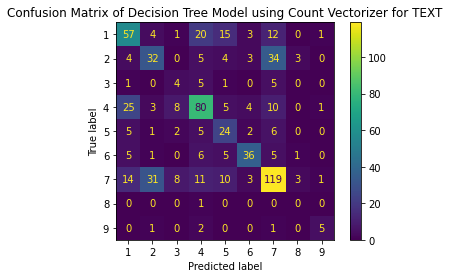

In [ ]:
# Stage 1 classifier + Accuracy
# Count vectorizer
pipeline = make_pipeline(ct,DecisionTreeClassifier())
pipeline.fit(x_tl, y_tl)
print("Accuracy: {}".format(pipeline.score(X_test, y_test)))
plot_confusion_matrix(pipeline, X_test, y_test)
plt.title('Confusion Matrix of Decision Tree Model using Count Vectorizer for TEXT')

Accuracy: 0.6701807228915663


Text(0.5, 1.0, 'Confusion Matrix of Random Forest Model using Count Vectorizer for TEXT')

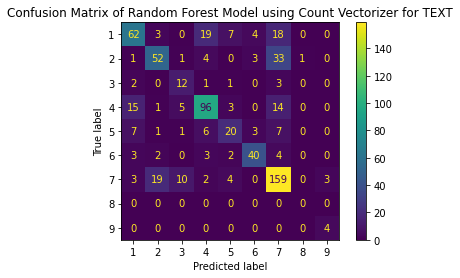

In [ ]:
# Stage 1 classifier + Accuracy
# Count vectorizer
pipeline = make_pipeline(ct,RandomForestClassifier())
pipeline.fit(x_tl, y_tl)
print("Accuracy: {}".format(pipeline.score(X_test, y_test)))
plot_confusion_matrix(pipeline, X_test, y_test)
plt.title('Confusion Matrix of Random Forest Model using Count Vectorizer for TEXT')

Accuracy: 0.6144578313253012


Text(0.5, 1.0, 'Confusion Matrix of Decision Tree Model using TF-IDF Vectorizer for TEXT')

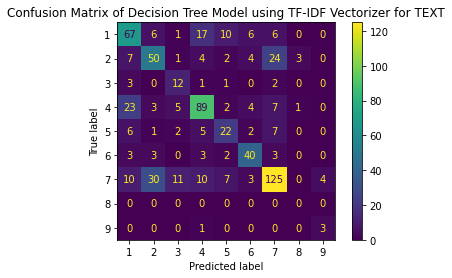

In [ ]:
# Tf-idf
# Stage 1 classifier + Accuracy
pipeline = make_pipeline(tft,DecisionTreeClassifier())
pipeline.fit(x_tl, y_tl)
print("Accuracy: {}".format(pipeline.score(X_test, y_test)))
plot_confusion_matrix(pipeline, X_test, y_test)
plt.title('Confusion Matrix of Decision Tree Model using TF-IDF Vectorizer for TEXT')

Accuracy: 0.6731927710843374


Text(0.5, 1.0, 'Confusion Matrix of Random Forest Model using TF-IDF Vectorizer for TEXT')

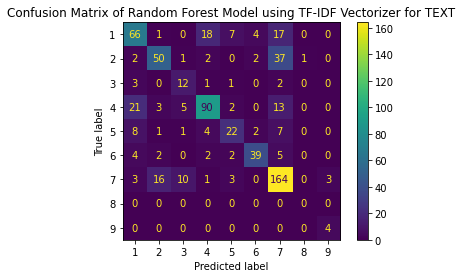

In [ ]:
# Tf-idf
# Stage 1 classifier + Accuracy
pipeline = make_pipeline(tft,RandomForestClassifier())
pipeline.fit(x_tl, y_tl)
print("Accuracy: {}".format(pipeline.score(X_test, y_test)))
plot_confusion_matrix(pipeline, X_test, y_test)
plt.title('Confusion Matrix of Random Forest Model using TF-IDF Vectorizer for TEXT')

Accuracy: 0.6325301204819277


Text(0.5, 1.0, 'Confusion Matrix of Decision Tree Model using TF-IDF trigrams Vectorizer for TEXT')

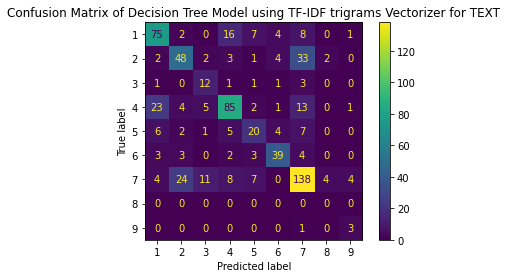

In [ ]:
# Tf-idf Trigrams
# Stage 1 classifier + Accuracy
pipeline = make_pipeline(tft_3,DecisionTreeClassifier())
pipeline.fit(x_tl, y_tl)
print("Accuracy: {}".format(pipeline.score(X_test, y_test)))
plot_confusion_matrix(pipeline, X_test, y_test)
plt.title('Confusion Matrix of Decision Tree Model using TF-IDF trigrams Vectorizer for TEXT')

In [ ]:
# Tf-idf Trigrams
# Stage 1 classifier + Accuracy
# Takes ~ > 35 min
pipeline = make_pipeline(tft_3,RandomForestClassifier())
pipeline.fit(x_tl, y_tl)
print("Accuracy: {}".format(pipeline.score(X_test, y_test)))


Accuracy: 0.6189759036144579


Text(0.5, 1.0, 'Confusion Matrix of Random Forest Model using TF-IDF trigrams Vectorizer for TEXT')

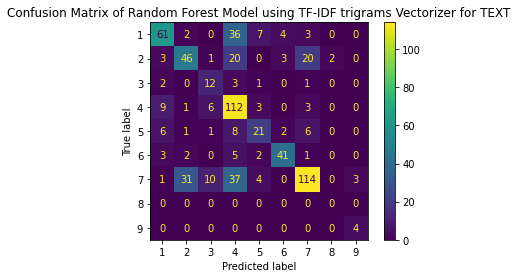

In [ ]:
# Plot the confusion matrix for the RF with TF-IDF of Trigrams
plot_confusion_matrix(pipeline, X_test, y_test)
plt.title('Confusion Matrix of Random Forest Model using TF-IDF trigrams Vectorizer for TEXT')

## 1.4 Text to predicted class

In [16]:
# Instantiate Models
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
nb = MultinomialNB()
svc = LinearSVC()

In [17]:
# Splitting Training Data 80% Train, 20% Test
#    Don't need to use the pipeline_df_merged dataframe because 
#    it's only difference from merged_df_label is gene and variation
#    are factorized
X_train_pred, X_test_pred, y_train_pred, y_test_pred = train_test_split(
    merged_df_label["TEXT"], merged_df_label["Class"], test_size=0.20)

In [18]:
# Convert text to word counts with CountVectorizer()
X_train_pred = cv.fit_transform(X_train_pred)
X_test_pred = cv.transform(X_test_pred)

# Get Stage 2 Test data so can train model & get predicted classes
X_test_stage2_pred = cv.transform(merged_df_label_test_stage2["TEXT"])

In [ ]:
# Convert text to word counts with Tf-IDF Trigrams
#X_train_pred = tft_3.fit_transform(X_train_pred.to_frame())
#X_test = tft_3.transform(X_test_pred.to_frame())

# Get Stage 2 Test data so can train model & get predicted classes
#X_test_stage2_text = merged_df_label_test_stage2["TEXT"].to_frame()
#X_test_stage2 = tft_3.transform(X_test_stage2_text)

In [ ]:
# Convert text to word counts with Tf-IDF
#X_train = tft.fit_transform(X_train.to_frame())
#X_test = tft.transform(X_test.to_frame())

# Get Stage 2 Test data so can train model & get predicted classes
#X_test_stage2_text = merged_df_label_test_stage2["TEXT"].to_frame()
#X_test_stage2 = tft.transform(X_test_stage2_text)

In [19]:
# Resampling training data
tl = RandomOverSampler()

# fit predictor and target variable
x_tl_pred, y_tl_pred = tl.fit_resample(X_train_pred, y_train_pred)

print('Original dataset shape', Counter(y_train_pred))
print('Resample dataset shape', Counter(y_tl_pred))

Original dataset shape Counter({7: 751, 4: 566, 1: 451, 2: 364, 6: 214, 5: 193, 3: 69, 9: 28, 8: 16})
Resample dataset shape Counter({4: 751, 7: 751, 2: 751, 1: 751, 5: 751, 6: 751, 3: 751, 9: 751, 8: 751})


/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)
Accuracy is: 0.5542168674698795


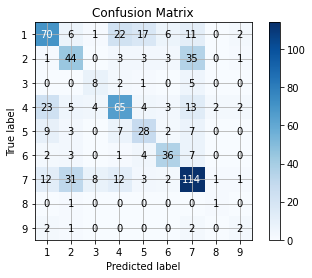

In [ ]:
# Train the model with training data and check accuracy. (Decision Tree)
# Fit the model
dt.fit(X_train_pred, y_train_pred)
# Get predicted classes using X_test
predicted_class_test = dt.predict(X_test_pred)
# Plot confusion matrix and get accuracy 
skplt.plot_confusion_matrix(y_test_pred, predicted_class_test)
print("Accuracy is: {}".format(accuracy_score(y_test_pred,predicted_class_test)))

In [ ]:
print(classification_report(y_test_pred, predicted_class_test))

              precision    recall  f1-score   support

           1       0.45      0.49      0.47       102
           2       0.46      0.44      0.45        88
           3       0.50      0.35      0.41        23
           4       0.67      0.67      0.67       151
           5       0.44      0.40      0.42        58
           6       0.48      0.55      0.51        49
           7       0.69      0.68      0.68       188
           8       0.33      1.00      0.50         1
           9       0.50      0.50      0.50         4

    accuracy                           0.57       664
   macro avg       0.50      0.56      0.51       664
weighted avg       0.57      0.57      0.57       664



In [ ]:
cohen_kappa_score(y_test_pred, predicted_class_test)

0.46993278699506513

In [ ]:
matthews_corrcoef(y_test_pred, predicted_class_test)

0.4846913370488775

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)
Accuracy is: 0.6039156626506024


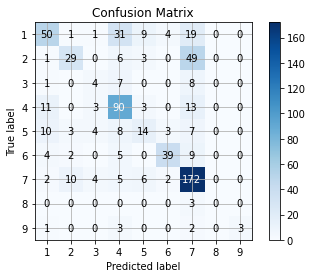

In [21]:
# Train the model with training data and check accuracy. (Random Forest)
# Fit the model
rf.fit(X_train_pred, y_train_pred)
# Get predicted classes using X_test
predicted_class_test = rf.predict(X_test_pred)
# Plot confusion matrix and get accuracy 
skplt.plot_confusion_matrix(y_test_pred, predicted_class_test)
print("Accuracy is: {}".format(accuracy_score(y_test_pred,predicted_class_test)))

In [ ]:
print(classification_report(y_test_pred, predicted_class_test))

              precision    recall  f1-score   support

           1       0.53      0.57      0.55       102
           2       0.70      0.42      0.52        88
           3       0.53      0.35      0.42        23
           4       0.75      0.73      0.74       151
           5       0.55      0.38      0.45        58
           6       0.71      0.55      0.62        49
           7       0.66      0.89      0.76       188
           8       0.33      1.00      0.50         1
           9       1.00      0.75      0.86         4

    accuracy                           0.65       664
   macro avg       0.64      0.63      0.60       664
weighted avg       0.66      0.65      0.64       664



In [ ]:
cohen_kappa_score(y_test_pred, predicted_class_test)

0.5639648590851598

In [ ]:
matthews_corrcoef(y_test_pred, predicted_class_test)

0.5694877413303301

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)
Accuracy is: 0.5617469879518072


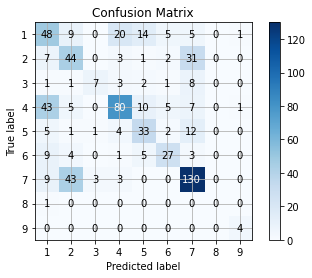

In [ ]:
# Train the model with training data and check accuracy.
# Fit the model
nb.fit(X_train_pred, y_train_pred)
# Get predicted classes using X_test
predicted_class_test = nb.predict(X_test_pred)
# Plot confusion matrix and get accuracy 
skplt.plot_confusion_matrix(y_test_pred, predicted_class_test)
print("Accuracy is: {}".format(accuracy_score(y_test_pred,predicted_class_test)))

In [ ]:
print(classification_report(y_test_pred, predicted_class_test))

              precision    recall  f1-score   support

           1       0.39      0.47      0.43       102
           2       0.41      0.50      0.45        88
           3       0.64      0.30      0.41        23
           4       0.70      0.53      0.60       151
           5       0.51      0.57      0.54        58
           6       0.64      0.55      0.59        49
           7       0.66      0.69      0.68       188
           8       0.00      0.00      0.00         1
           9       0.67      1.00      0.80         4

    accuracy                           0.56       664
   macro avg       0.51      0.51      0.50       664
weighted avg       0.58      0.56      0.56       664

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

In [ ]:
cohen_kappa_score(y_test_pred, predicted_class_test)

0.4614220371438844

In [ ]:
matthews_corrcoef(y_test_pred, predicted_class_test)

0.46302473092413554

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)
Accuracy is: 0.5798192771084337


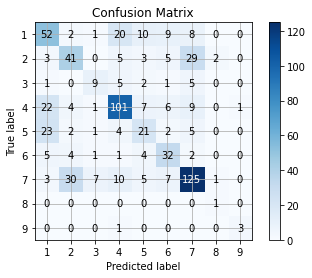

In [ ]:
# Train the model with training data and check accuracy.
# Fit the model
svc.fit(X_train_pred, y_train_pred)
# Get predicted classes using X_test
predicted_class_test = svc.predict(X_test_pred)
# Plot confusion matrix and get accuracy 
skplt.plot_confusion_matrix(y_test_pred, predicted_class_test)
print("Accuracy is: {}".format(accuracy_score(y_test_pred,predicted_class_test)))

In [ ]:
print(classification_report(y_test_pred, predicted_class_test))

              precision    recall  f1-score   support

           1       0.48      0.51      0.49       102
           2       0.49      0.47      0.48        88
           3       0.45      0.39      0.42        23
           4       0.69      0.67      0.68       151
           5       0.40      0.36      0.38        58
           6       0.52      0.65      0.58        49
           7       0.68      0.66      0.67       188
           8       0.25      1.00      0.40         1
           9       0.75      0.75      0.75         4

    accuracy                           0.58       664
   macro avg       0.52      0.61      0.54       664
weighted avg       0.58      0.58      0.58       664



In [ ]:
cohen_kappa_score(y_test_pred, predicted_class_test)

0.4844533991578983

In [ ]:
matthews_corrcoef(y_test_pred, predicted_class_test)

**Random forests produced the best results therefore this is the data we will use to feed into the stacked model.**

## 1.5 Random Forest Model - Genes + Variations + Predicted Class (from text)

In [22]:
# Use the model to predict the classes for the entire merged_df_label. 
# Then use this data in the next part of the model
#    This is because we want the predicted classes for all of our rows, not
#    just the rows that we previously sampled.
predicted_class = rf.predict(cv.transform(merged_df_label["TEXT"]))

In [23]:
# Get predicted classes for our stage 2 test data.
predicted_test_class_stage2 = rf.predict(X_test_stage2_pred)

In [24]:
# Copy our dataframes, so we can prevent unexpected problems while modifying them.
merged_to_use = merged_df_label.copy()
merged_to_use_test = merged_df_label_test_stage2.copy()

In [25]:
# Modify merged_to_use dataframes
merged_to_use["PredictedClass"] = pd.Series(predicted_class)
del merged_to_use["Gene"]
del merged_to_use["Variation"]
del merged_to_use["Class"]
del merged_to_use["TEXT"]
# merged_to_use features: 'ID', 'PredictedClass'

merged_to_use_test["PredictedClass"] = pd.Series(predicted_test_class_stage2)
del merged_to_use_test["Gene"]
del merged_to_use_test["Variation"]
del merged_to_use_test["TEXT"]
# merged_to_use_test features: 'ID', 'PredictedClass'

In [26]:
# Merging the PredictedClass to the pipeline_df_merged
# Using the pipeline_df_merged instead of merged_df_label because 
# variables are already factorized (except TEXT).
merged_df_label_resample = pd.merge(pipeline_df_merged, merged_to_use, on="ID")
merged_df_label_resample_test = pd.merge(pipeline_test_df_merged, merged_to_use_test, on="ID")

In [27]:
merged_df_label_resample.head(n=1)

,ID,Gene,Variation,Class,TEXT,PredictedClass
0,0,0,0,1,last activ identifi reveal elus silenc silenc ...,1


In [28]:
del merged_df_label_resample_test["TEXT"]
del merged_df_label_resample_test["ID"]
merged_df_label_resample_test.head(n=1)

,Gene,Variation,PredictedClass
0,0,0,4


In [29]:
# Split merged_df_label_resample, so it can be resampled
# Using an 80% Training, 20% Test Split
X_train_p_all, X_test_p_all, y_train_p_all, y_test_p_all = train_test_split(
    merged_df_label_resample[["Gene", "Variation", 'PredictedClass']],
    merged_df_label_resample["Class"],
    test_size=0.20)

In [30]:
X_train_p_all.head(n=1)

,Gene,Variation,PredictedClass
2157,194,3,4


In [31]:
y_train_p_all.head(n=1)

2157    4
Name: Class, dtype: int64

In [32]:
# Resample the training variables from  merged_df_label_resample
tl = RandomOverSampler()

# Fit predictor and target variable
x_tl_p_all, y_tl_p_all = tl.fit_resample(X_train_p_all, y_train_p_all)

print('Original dataset shape', Counter(y_train_p_all))
print('Resample dataset shape', Counter(y_tl_p_all))

Original dataset shape Counter({7: 760, 4: 542, 1: 457, 2: 362, 6: 219, 5: 199, 3: 72, 9: 27, 8: 14})
Resample dataset shape Counter({4: 760, 1: 760, 7: 760, 6: 760, 3: 760, 5: 760, 2: 760, 8: 760, 9: 760})


In [ ]:
rf.fit(x_tl_p_all, y_tl_p_all)

RandomForestClassifier()

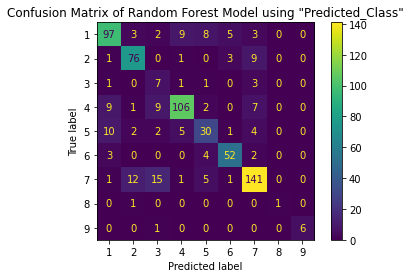

In [ ]:
plot_confusion_matrix(rf, X_test_p_all, y_test_p_all)
plt.title('Confusion Matrix of Random Forest Model using "Predicted_Class"')  
plt.show()  

In [ ]:
rf.score(X_test_p_all, y_test_p_all)

0.7771084337349398

## 1.6 Benchmarking with Multi Class Loss

* Logistic Regression
* Multinomial Naive Bayes
* Support Vector Classification
* Random Forest

In [33]:
# Define the models being used.

models = [
    RandomForestClassifier(n_estimators=1000, max_depth=20, random_state=0),
    SVC(probability=True),
    MultinomialNB(alpha=0.01),
    LogisticRegression(random_state=0, max_iter=1000)
]

### 1.6.1 Benchmarking with Predicted Class - Multi Class Loss

In [ ]:
# Set the training and test variables for the models.
#    x_tl_p_all and y_tl_p_all are from section 1.5
#    They are resampled, gene and variation are factorized data for training
X_tl_bench_p = x_tl_p_all # Features: 'Gene', 'Variation', 'PredictedClass'
y_tl_bench_p = y_tl_p_all # Features: 'Class'

In [ ]:
# Run the individual models & get their accuracies.

CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_tl_bench_p, y_tl_bench_p, scoring='neg_log_loss', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'neg_log_loss'])

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

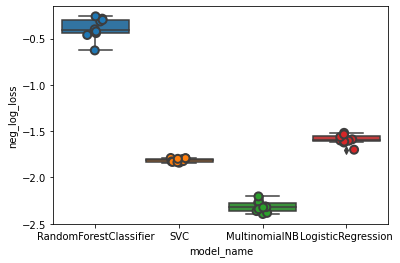

In [ ]:
# Plotting the models' accuracies.
sns.boxplot(x='model_name', y='neg_log_loss', data=cv_df)
sns.stripplot(x='model_name', y='neg_log_loss', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
# Look at mean accuracy of each model

cv_df.groupby('model_name').neg_log_loss.mean()

model_name
LogisticRegression       -1.589087
MultinomialNB            -2.317950
RandomForestClassifier   -0.392611
SVC                      -1.812927
Name: neg_log_loss, dtype: float64

### 1.6.2 Benchmarking with Text - Multi Class Loss

In [34]:
# Set the training and test variables for the models.
#    x_tl and y_tl are from 1.3 of the notebook.
#    x_tl and y_tl are resampled and factoried data for training.
X_tl_bench_t = x_tl # X_tl_bench = 'Gene', 'Variation', 'TEXT'
y_tl_bench_t = y_tl # Y_tl_bench = 'Class'

In [35]:
# Convert X_tl's TEXT to tf-idf
X_tl_bench_tft = tft.fit_transform(X_tl_bench_t)

In [1]:
# Run the individual models & get their accuracies.
# This runs for > 40 minutes.
CV_t = 10
cv_df_t = pd.DataFrame(index=range(CV_t * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_tl_bench_tft, y_tl_bench_t, scoring='neg_log_loss', cv=CV_t)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df_t = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'neg_log_loss'])


NameError: name 'pd' is not defined

In [ ]:
# Plotting the models' accuracies.
sns.boxplot(x='model_name', y='neg_log_loss', data=cv_df_t)
sns.stripplot(x='model_name', y='neg_log_loss', data=cv_df_t, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

ValueError: Could not interpret input 'model_name'

In [ ]:
# Look at mean accuracy of each model

cv_df_t.groupby('model_name').neg_log_loss.mean()

model_name
LinearSVC                 0.818123
LogisticRegression        0.690018
MultinomialNB             0.691645
RandomForestClassifier    0.895548
Name: accuracy, dtype: float64

## 1.7 Benchmarking with - Accuracy

In [ ]:
# Define the models being used.

models_a = [
    RandomForestClassifier(n_estimators=1000, max_depth=20, random_state=0),
    LinearSVC(dual=False),
    MultinomialNB(alpha=0.01),
    LogisticRegression(random_state=0, max_iter=1000)
]

### 1.7.1 Benchmarking with Predicted Class- Accuracy

In [ ]:
# Set the training and test variables for the models.
#    x_tl_p_all and y_tl_p_all are from section 1.5
#    They are resampled, gene and variation are factorized data for training
X_tl_bench_p = x_tl_p_all # Features: 'Gene', 'Variation', 'PredictedClass'
y_tl_bench_p = y_tl_p_all # Features: 'Class'

In [ ]:
# Run the individual models & get their accuracies.

CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models_a:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_tl_bench_p, y_tl_bench_p, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [ ]:
# Plotting the models' accuracies.
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
# Look at mean accuracy of each model

cv_df.groupby('model_name').accuracy.mean()

### 1.7.2 Benchmarking with Text - Accuracy

In [ ]:
# Set the training and test variables for the models.
#    x_tl and y_tl are from 1.3 of the notebook.
#    x_tl and y_tl are resampled and factoried data for training.
X_tl_bench_t = x_tl # X_tl_bench = 'Gene', 'Variation', 'TEXT'
y_tl_bench_t = y_tl # Y_tl_bench = 'Class'

In [ ]:
# Convert X_tl's TEXT to tf-idf
X_tl_bench_tft = tft.fit_transform(X_tl_bench_t)

In [ ]:
# Run the individual models & get their accuracies.
# This runs for > 40 minutes.
CV_t = 10
cv_df_t = pd.DataFrame(index=range(CV_t * len(models)))
entries = []
for model in models_a:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_tl_bench_tft, y_tl_bench_t, scoring='accuracy', cv=CV_t)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df_t = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [ ]:
# Plotting the models' accuracies.
sns.boxplot(x='model_name', y='accuracy', data=cv_df_t)
sns.stripplot(x='model_name', y='accuracy', data=cv_df_t, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
# Look at mean accuracy of each model

cv_df_t.groupby('model_name').accuracy.mean()

## 1.8 Stacking Models

### 1.7.1 Stacking with Predicted Class

In [ ]:
estimators = [('rf', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=0)),
              ('rfe', RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=10, random_state=0)),
              ('svc', LinearSVC()), 
              #('MNB', MultinomialNB(alpha=0.001)),
              ('LR', LogisticRegression(random_state=0))]

lr = SVC(probability=True)
sclf_p = StackingClassifier(estimators=estimators, final_estimator=lr, stack_method='auto', cv=10)
sclf_p.fit(x_tl_p_all, y_tl_p_all)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/shared-libs/python3.7/py/

StackingClassifier(cv=10,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=10,
                                                       n_estimators=200,
                                                       random_state=0)),
                               ('rfe',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=10,
                                                       n_estimators=200,
                                                       random_state=0)),
                               ('svc', LinearSVC()),
                               ('LR', LogisticRegression(random_state=0))],
                   final_estimator=SVC(probability=True))

Accuracy is: 0.8358433734939759


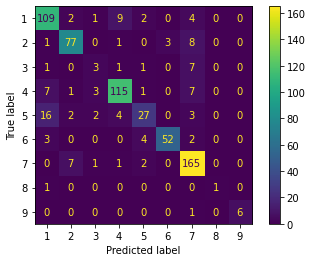

In [ ]:
# Use trained model to predict the test data (stage 1).
y_prediction_p = sclf_p.predict(X_test_p_all)
plot_confusion_matrix(sclf_p, X_test_p_all, y_test_p_all)
print("Accuracy is: {}".format(accuracy_score(y_test_p_all, y_prediction_p)))

In [ ]:
# Get classification report
print(classification_report(y_test_p_all, y_prediction_p))

              precision    recall  f1-score   support

           1       0.79      0.86      0.82       127
           2       0.87      0.86      0.86        90
           3       0.30      0.23      0.26        13
           4       0.88      0.86      0.87       134
           5       0.73      0.50      0.59        54
           6       0.95      0.85      0.90        61
           7       0.84      0.94      0.88       176
           8       1.00      0.50      0.67         2
           9       1.00      0.86      0.92         7

    accuracy                           0.84       664
   macro avg       0.82      0.72      0.75       664
weighted avg       0.83      0.84      0.83       664



In [ ]:
cohen_kappa_score(y_test_p_all, y_prediction_p)

0.7976102257506145

In [ ]:
matthews_corrcoef(y_test_p_all, y_prediction_p)

0.7986675126358339

In [ ]:
prob_pred_p = sclf_p.predict_proba(merged_df_label_resample_test)
pred_df_p = pd.DataFrame(prob_pred_p)

In [ ]:
id_col_p = pd.Series(pipeline_test_df_merged["ID"])
pred_df_p = pred_df_p.join(id_col_p)

In [ ]:
pred_df_ordered_p = pred_df_p.copy()
ID_col_p = pred_df_ordered_p["ID"]
pred_df_ordered_p.drop(["ID"], axis=1, inplace=True)
pred_df_ordered_p.insert(0, "ID", ID_col_p)
pred_df_ordered_p.columns = [
    "ID","class1","class2",
    "class3","class4","class5",
    "class6","class7","class8",
    "class9",
]
pred_df_ordered_p.head(n=2)

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,1,0.591910,0.140212,0.004980,0.123668,0.091926,0.033940,0.010545,0.000833,0.001987
1,2,0.866634,0.001121,0.001066,0.035830,0.064090,0.024469,0.004854,0.000321,0.001612


In [ ]:
pred_df_ordered_p.to_csv("submit_to_kaggle_SVC_PC_noNB.csv", index=False)

### 1.7.2 Stacking with Text

In [ ]:
# Set the training and test variables for the model.
# Using training variables from the bench w/ text (not predicted class)
X_tl_stack = X_tl_bench_tft
y_tl_stack = y_tl_bench_t 

In [ ]:
# Convert X_test to tf-idf
#    Use .transform not .fit_transform to ensure 
#    that it is the same size is x_tl_stack.
#    To prevent error, make sure that you've ran .fit_transform(X_tl_bench_t) in
#    the benchmarking section.   
X_test_tft = tft.transform(X_test)

In [ ]:
# Stacking with TF-IDF
# Runs for ~ 20 minutes

estimators = [('rf', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=0)),
              ('rfe', RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=10, random_state=0)),
              ('svc', LinearSVC()), 
              ('MNB', MultinomialNB(alpha=0.001)),
              ('LR', LogisticRegression(random_state=0))]

lr = SVC(probability=True)
sclf = StackingClassifier(estimators=estimators, final_estimator=lr, stack_method='auto', cv=10)
sclf.fit(X_tl_stack, y_tl_stack)

NameError: name 'RandomForestClassifier' is not defined

In [ ]:
# Use trained model to predict the test data from splitting training set.
y_prediction = sclf.predict(X_test_tft)
plot_confusion_matrix(sclf, X_test_tft, y_test)
print("Accuracy is: {}".format(accuracy_score(y_test, y_prediction)))

NameError: name 'sclf' is not defined

In [ ]:
print(classification_report(y_test, y_prediction))

NameError: name 'classification_report' is not defined

In [ ]:
cohen_kappa_score(y_test, y_prediction)

0.5722219753854356

In [ ]:
matthews_corrcoef(y_test, y_prediction)

0.5732133820235602

In [ ]:
test_stage2_no_ID = pipeline_test_df_merged.copy()
del test_stage2_no_ID['ID']

In [ ]:
test_stage2_tft = tft.transform(test_stage2_no_ID)

In [ ]:
prob_pred = sclf.predict_proba(test_stage2_tft)
pred_df = pd.DataFrame(prob_pred)

In [ ]:
id_col = pd.Series(pipeline_test_df_merged["ID"])
pred_df = pred_df.join(id_col)

In [ ]:
pred_df_ordered = pred_df.copy()
ID_col = pred_df_ordered["ID"]
pred_df_ordered.drop(["ID"], axis=1, inplace=True)
pred_df_ordered.insert(0, "ID", ID_col)
pred_df_ordered.columns = [
    "ID","class1","class2",
    "class3","class4","class5",
    "class6","class7","class8",
    "class9",
]
pred_df_ordered.head(n=2)

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,1,0.527326,0.026832,0.003279,0.162770,0.085973,0.171798,0.021796,0.000095,0.000131
1,2,0.840295,0.006199,0.000462,0.122412,0.010055,0.014437,0.005770,0.000232,0.000139


In [ ]:
pred_df_ordered.to_csv("submit_to_kaggle_SVC_text.csv", index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f3429806-221b-4e18-a695-754269d0015a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>